# Tutorial: Programming with Pulser

This tutorial demonstrates how to use Pulser to program the evolution of a quantum system. Two programs are presented:

- [In a first part](#preparing-an-atom-in-the-rydberg-state), we excite one atom from its ground state to its excited state using a constant pulse. 
- [In a second part](#adiabatic-preparation-of-an-anti-ferromagnetic-state), we show how to prepare a quantum system of 9 atoms in an anti-ferromagnetic state using time-dependent pulses.

This tutorial follows the step-py-step guide on how to create a quantum program using Pulser that is provided in the [programming page](../programming.md). For more information regarding the steps followed and the mathematical objects at stake, please refer to this page.

In [1]:
import numpy as np
import pulser
from matplotlib import pyplot as plt

## Preparing an atom in the Rydberg state

As presented in ["Programming a neutral-atom QPU"](../programming.md), Pulser enables you to program [an Hamiltonian](../programming.md#hamiltonian-evolves-the-state) composed of an [interaction Hamiltonian](../programming.md#interaction-hamiltonian) and a [drive Hamiltonian](../programming.md#driving-hamiltonian).

Let's program this Hamiltonian $H$ such that an atom initially in the ground state $\left|g\right>$ is measured in the Rydberg state $\left|r\right>$ after a time $\Delta t$.

Since we are working with a single atom, there is no [interaction Hamiltonian](../programming.md#interaction-hamiltonian). In this specific example, $H=H^D$. For a simple pulse having a duration $\Delta t$, a constant amplitude along time $\Omega$, detuning $\delta=0$ and phase $\phi=0$ [the Hamiltonian between 0 and Δt is](../programming.md#hamiltonian-evolves-the-state):

$$ H(t) = \hbar\frac{\Omega}{2} (|g\rangle\langle r| + |r\rangle\langle g|)$$

To find the atom in the Rydberg state at the end of the program, we want $\Omega \Delta t = \pi$ so we choose $\Delta t=1000\ ns$ and $\Omega=\pi\ rad/\mu s$.
<details>


- We can use the Bloch sphere representation

    The pulse being of duration $\Delta t$, of detuning $\delta=0$, of phase $\phi=0$ and constant amplitude $\Omega$, the pulse will make the vector representing the state rotate by an angle $\Omega \Delta t$ around the axis $(1, 0, 0)$. To go from the ground state $\left|g\right>$ to the excited state $\left|r\right>$ by rotating around the $(1, 0, 0)$ axis, we need to make a rotation of angle $\pi$.

    Therefore we get that the final state will be the Rydberg state if $\Omega \Delta t = \pi$. From this condition, we choose $\Delta t = 1000\ ns$ and $\Omega=\pi\ rad/\mu s$. 

    <center>
        <figure>
            <img src="../files/bloch_pi_rotation.png" alt="Bloch rotation of angle pi" width="300">
            <figcaption>The Bloch vector rotates around the x axis by an angle of π, going from the ground state to the Rydberg state.</figcaption>
        </figure>
    </center>


- We can compute the final state knowing the initial state

    The initial state being the ground state and the Hamiltonian $H$ being constant along time, [the final state is](../programming.md#hamiltonian-evolves-the-state):

    $$
    \begin{align}
    \left|\Psi_f\right> &= e^{-\frac{i}{\hbar} H \Delta t} \left|g\right> \\
    &= \left(\cos\left(\frac{\Omega}{2} \Delta t\right)(|g\rangle\langle g| + |r\rangle\langle r|) - i \sin\left(\frac{\Omega}{2} \Delta t\right)(|g\rangle\langle r| + |r\rangle\langle g|)\right)\left|g\right>\\
    &= \cos\left(\frac{\Omega}{2} \Delta t\right)\left|g\right> - i \sin\left(\frac{\Omega}{2} \Delta t\right)\left|r\right>
    \end{align}
    $$

    The final state will be the Rydberg state $\left|r\right>$ if $\frac{\Omega}{2} \Delta t = \frac{\pi}{2}$. From this condition, we choose $\Delta t = 1000\ ns$ and $\Omega=\pi\ rad/\mu s$.

</details>

<p>
<br>
</p>

### 1. Picking a `Device`

We need a `Device` that will enable us to target the transition between the ground and the Rydberg state. `pulser.AnalogDevice` contains the `Rydberg.Global` channel, which targets the transition between these two states. Let's select this `Device`!

We can check in the device specifications (accessed via `Device.specs`) that the `AnalogDevice` supports the ground-rydberg transition.

In [2]:
device = pulser.AnalogDevice
print(device.specs)

A realistic device for analog sequence execution.

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 80
 - Maximum distance from origin: 38 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 6000 ns
 - Maximum number of runs: 2000

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_

### 2. Creating the `Register`

We want to excite one atom. There will therefore be only one atom in the `Register`, whose position does not matter because it will not interact with another atom.

Let's then create a `Register` containing one atom at the coordinate (0, 0).

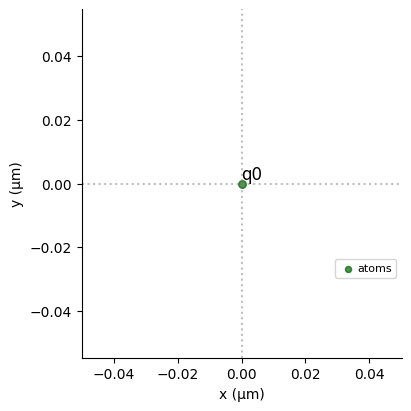

In [3]:
register = pulser.Register.from_coordinates([(0, 0)], prefix="q")
register.draw()

At this stage, we can initialize the `Sequence`, our quantum program. This will check that the created `Register` matches the parameters set by the `Device` we picked. 

In [4]:
sequence = pulser.Sequence(register, device)

### 3. Picking the Channels

The only channel we need to pick is a `Rydberg` channel to target the transition between $\left|g\right>$ and $\left|r\right>$. Since we only have one atom, the addressing does not matter, the `Rydberg.Global` channel will address the atom in the register. 

In [5]:
sequence.declare_channel("rydberg_global", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The states used in the computation are ['r', 'g']


At this stage, the atom is initialized in the ground state $\left|g\right>$ and only two energy levels are used in the computation - the state of the system is described by a qubit.

### 4. Adding the pulses

Let's now add the pulse of duration $\Delta t = 1000\ ns$, amplitude $\Omega=\pi\ rad/\mu s$, detuning $\delta=0$ and phase $\phi=0$ to the `Rydberg.Global` channel to modify the state of the atom and make it reach the state $\left|r\right>$.

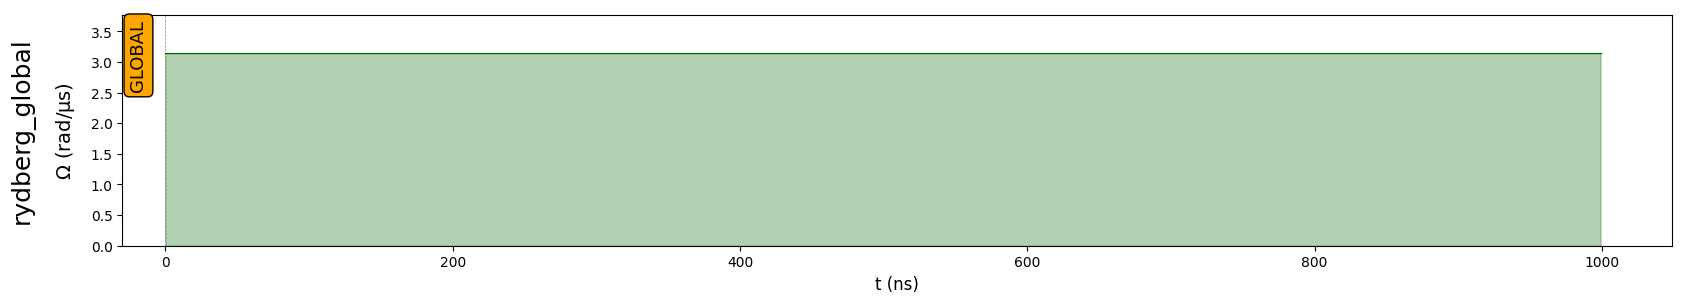

In [6]:
pi_pulse = pulser.Pulse.ConstantPulse(1000, np.pi, 0, 0)
sequence.add(pi_pulse, "rydberg_global")
sequence.draw(mode="input")

### Executing the Pulse Sequence

We are now done with our first Pulser program! We can now submit it to a backend for execution. Pulser provides multiple backends, notably the QPUs, but also a backend to simulate small quantum systems on your laptop based on **QuTip**. Let's use this `QutipBackend` to simulate the final state of the system: 

In [7]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()

When running an experiment on a neutral-atom QPU, the output of the quantum program is the sampling of the final state. It is a dictionnary associating to each measured state the number of times it was measured.

In [8]:
result.sample_final_state(1000)

Counter({'1': 1000})

When measuring in the ground-rydberg basis, [the ground state is labelled "0" and the rydberg state "1"](../conventions.md#state-preparation-and-measurement). For each of the 1000 measurements we did, the atom was measured in the Rydberg state, which means we designed our quantum program correctly!

## Adiabatic preparation of an Anti-Ferromagnetic State

Let's now program the [Ising Hamiltonian](../programming.md#ising-hamiltonian) such that a set of 9 atoms initially in the ground state $\left|ggggggggg\right>$ are prepared in an antiferromagnetic state $\left|rgrgrgrgr\right>$.

To reach the desired antiferromagentic state, we can take advantage of the [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_theorem). The idea is to use a time-dependent Hamiltonian that changes slowly so that the system stays in its ground state. Therefore, we must choose a final Hamiltonian that has the antiferromagnetic state as its ground state.

This final Hamiltonian should simultaneously favor having the largest number of atoms in the $\left|r\right>$ state (by having $\delta > 0$) and discourage nearest neighbors from being both in $\left|r\right>$ (via the  [interaction Hamiltonian](../programming.md#ising-hamiltonian)). When these contributions are appropriately balanced, we get an Hamiltonian with $\left|rgrgrgrgr\right>$ as its ground state.

Let's follow the protocol from [this paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070), where we define the parameters with respect to the interaction strength between nearest neighbours, $U$ (see Table 1 of the paper):

$$
U = 2\pi\ rad/\mu s\\
\Omega_{max} = 2 U\\
\delta_0 = -6 U\\
\delta_f = 2U\\
t_{rise} = 252\ ns,\ t_{fall} = 500\ ns\\
t_{sweep} = \frac{\delta_f - \delta_0 [rad\cdot\mu s^{-1}]}{2 \pi \cdot 10\ [rad\cdot\mu s^{-2}]}
$$

and define $\Omega(t)$ and $\delta(t)$ over time as (see Figure 1 (b)): 
<center>
<img src="../files/AF_Ising_program.png" alt="AF Pulse Sequence" width="300">
</center>

The [Hamiltonian](../programming.md#hamiltonian-evolves-the-state) we are implementing is (the phase is constant and equal to $0$ over time):

$$H = \hbar \sum_i \left (\frac{\Omega(t)}{2} \left(|g\rangle\langle r| + |r\rangle\langle g|\right) - \delta(t) |r\rangle\langle r| + \sum_{j<i}U_{ij}\hat{n}_i \hat{n}_j \right)$$

where $U_{ij} = \frac{C_6}{\hbar R_{ij}^6}$.

In [9]:
# Parameters in rad/µs
U = 2 * np.pi
Omega_max = 2.0 * U
delta_0 = -6 * U
delta_f = 2 * U

# Parameters in ns
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

### 1. Picking a `Device`

We need a `Device` that will enable us to target the transition between the ground and the rydberg state. As above, we select `pulser.AnalogDevice` since it contains the `Rydberg.Global` channel, that targets the transition between these two states.

In [10]:
device = pulser.AnalogDevice
print(device.specs)

A realistic device for analog sequence execution.

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 80
 - Maximum distance from origin: 38 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 6000 ns
 - Maximum number of runs: 2000

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_

### 2. Creating the `Register`

Let's keep following the [protocol](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070) and create the `Register`. We place the atoms in a square lattice, such that the distance between two neighbouring atoms (that is, the spacing of the square layout) is the same, and we choose that distance such that $\frac{C_6}{R^6}=\hbar U$.

Interatomic Radius is: 7.186760677748386µm.


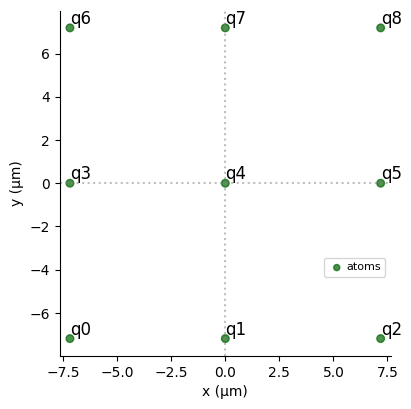

In [11]:
R_interatomic = (device.interaction_coeff / U) ** (1 / 6)
N_side = 3
register = pulser.Register.square(N_side, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
register.draw()

Note: In Pulser, we can access the interaction coefficient $\frac{C_6}{\hbar}$ with `device.interaction_coeff`

Let's now initialize our quantum program, the `Sequence`, and check that the created `Register` matches the parameters set by the `Device` we picked: 

In [12]:
sequence = pulser.Sequence(register, device)

### 3. Picking the Channels

The only channel we need to pick is a `Rydberg` channel to target the transition between $\left|g\right>$ and $\left|r\right>$. Since we want to apply the same amplitude, detuning and phase on each atom, we can use the `Rydberg.Global` channel: 

In [13]:
sequence.declare_channel("rydberg_global", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The states used in the computation are ['r', 'g']


At this stage, all the atoms are initialized in the state $\left|g\right>$ and only two energy levels are used in the computation, i.e.  each atom is a qubit and the initial state of the quantum system is $\left|ggggggggg\right>$.

The interaction Hamiltonian is now completely determined, and will not change over time.

### 4. Adding the pulses

Let's now define the driving Hamiltonian at each nanosecond between $0$ and $t_{tot}=t_{rise}+t_{sweep}+t_{fall}$. We follow the program that we described above. The `Sequence` will be composed of three pulses:
- A first "rise" pulse with:
    - Duration: $t_{rise}$
    - Amplitude: $0 \rightarrow \Omega_{max}$
    - Detuning: $\delta_0$
    - Phase: $0$
- A second "sweep" pulse with:
    - Duration: $t_{sweep}$
    - Amplitude: $\Omega_{max}$
    - Detuning: $\delta_0 \rightarrow\delta_{final}$
    - Phase: $0$
- A third "fall" pulse with:
    - Duration: $t_{fall}$
    - Amplitude: $\Omega_{max}\rightarrow 0$
    - Detuning: $\delta_{final}$
    - Phase: $0$  

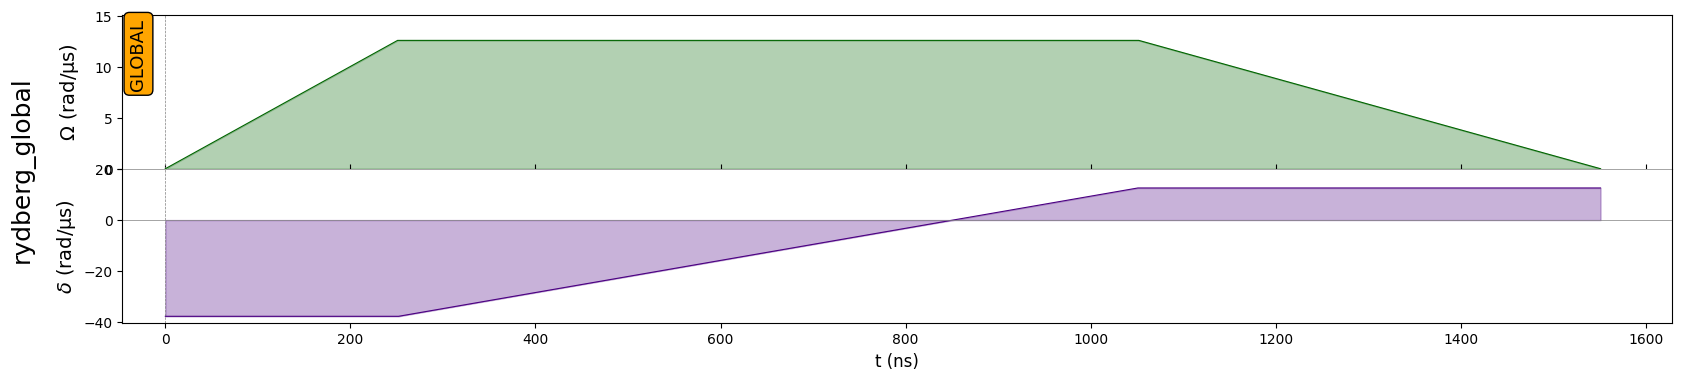

In [14]:
rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega_max, pulser.RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)
sequence.add(rise, "rydberg_global")
sequence.add(sweep, "rydberg_global")
sequence.add(fall, "rydberg_global")
sequence.draw(mode="input")

### Executing the Pulse Sequence

We are now done with this program! Let's use the `QutipBackend` to simulate the final state of the system: 

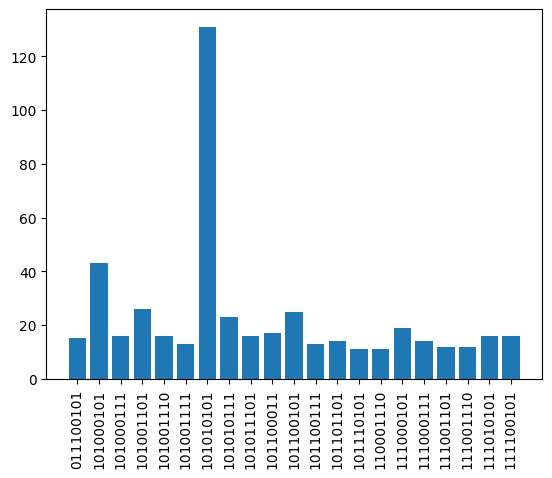

In [15]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()
counts = result.sample_final_state(1000)
# Let's plot the histogram associated to the measurements
# Let's select only the states that are measured more than 10 times
most_freq = {k: v for k, v in counts.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

The state that is measured the most frequently is the $\left|101010101\right>\rightarrow\left|rgrgrgrgr\right>$: our quantum program correctly excites the ground sate $\left|ggggggggg\right>$ into the state $\left|rgrgrgrgr\right>$.